In [20]:
import torch
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# ------------------
# SETTINGS
# ------------------

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_HIDDEN_1 = 75
NUM_HIDDEN_2 = 45
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [23]:
from distutils.version import LooseVersion as Version
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

if torch.__version__ <= Version("1.7"):
    torch.set_deterministic(True)
else:
    torch.use_deterministic_algorithms(True)

C:\Users\halig\AppData\Local\Temp\ipykernel_15824\1245048091.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if torch.__version__ <= Version("1.7"):


In [24]:
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

In [25]:
def get_dataloader_mnist(batch_size,num_worker=0,
                         train_transforms=None,
                         test_transforms=None,
                         validation_fraction=None,
                         ):
    
    if train_transforms is None:
        train_transforms = transforms.ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='mnist_3',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)
    
    valid_dataset = datasets.MNIST(root='mnist_3',
                                   train=True,
                                   transform=test_transforms)
    
    test_dataset = datasets.MNIST(root='mnist_3',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_worker,
                                  drop_last=True,
                                  sampler=train_sampler)
        
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_worker,
                                  sampler=valid_sampler)
    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_worker,
                                  drop_last=True,
                                  shuffle=True)
    
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_worker,
                             shuffle=False)
    
    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

In [26]:
train_loader, valid_loader, test_loader = get_dataloader_mnist(batch_size=BATCH_SIZE, 
                                                               validation_fraction=0.1)

In [27]:
for images, labels in train_loader:
    print("Image batch dimensions: ", images.shape)
    print("Image label dimensions: ", labels.shape)
    print("Class labels of 10 examples: ", labels[:10])
    break

Image batch dimensions:  torch.Size([256, 1, 28, 28])
Image label dimensions:  torch.Size([256])
Class labels of 10 examples:  tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


In [28]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, 
               num_hidden_2, num_classes, drop_prob,):
        super().__init__()

        self.network = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),

            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),

            torch.nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

In [29]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_prob=0.5,
                             num_classes=10)

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [37]:

def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [38]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer, device):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % 50:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list


In [39]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

Epoch: 001/050 | Batch 0000/0210 | Loss: 0.1221
Epoch: 001/050 | Batch 0050/0210 | Loss: 0.1192
Epoch: 001/050 | Batch 0100/0210 | Loss: 0.1105
Epoch: 001/050 | Batch 0150/0210 | Loss: 0.0906
Epoch: 001/050 | Batch 0200/0210 | Loss: 0.1020
Epoch: 001/050 | Train: 98.14% | Validation: 97.62%
Time elapsed: 0.22 min
Epoch: 002/050 | Batch 0000/0210 | Loss: 0.0458
Epoch: 002/050 | Batch 0050/0210 | Loss: 0.0843
Epoch: 002/050 | Batch 0100/0210 | Loss: 0.1079
Epoch: 002/050 | Batch 0150/0210 | Loss: 0.0523
Epoch: 002/050 | Batch 0200/0210 | Loss: 0.0810
Epoch: 002/050 | Train: 98.54% | Validation: 97.58%
Time elapsed: 0.45 min
Epoch: 003/050 | Batch 0000/0210 | Loss: 0.0434
Epoch: 003/050 | Batch 0050/0210 | Loss: 0.0877
Epoch: 003/050 | Batch 0100/0210 | Loss: 0.0992
Epoch: 003/050 | Batch 0150/0210 | Loss: 0.0743
Epoch: 003/050 | Batch 0200/0210 | Loss: 0.0424
Epoch: 003/050 | Train: 98.69% | Validation: 97.45%
Time elapsed: 0.68 min
Epoch: 004/050 | Batch 0000/0210 | Loss: 0.0539
Epoch: 

In [40]:
import os

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader):

    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhw_img[idx], cmap='binary')
        ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
        ax.axison = False

    plt.tight_layout()
    plt.show()


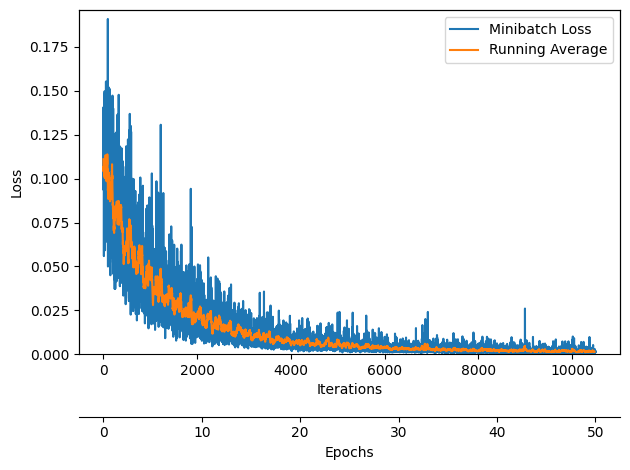

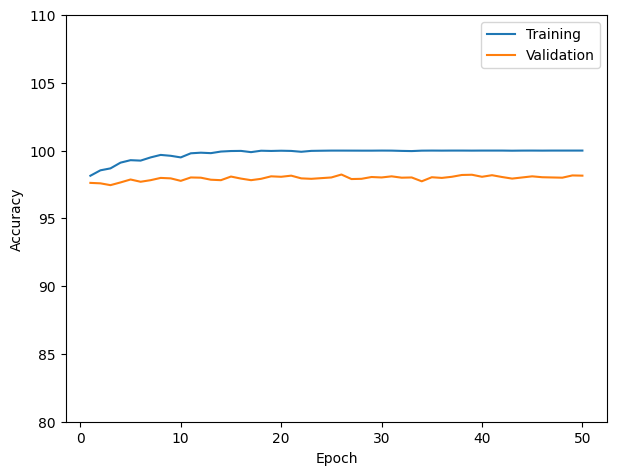

In [44]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 110])
plt.show()